#### Imports

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import datetime

#for BERT
import transformers

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6161590485515472644
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22723493888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11428453672654803780
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
2.5.0


#### Data loading

In [5]:
ner_labelled = pd.read_csv('training_data/training_characteristics.csv', index_col=0)

In [6]:
labels = ner_labelled.columns[1:].to_list()

In [7]:
len(labels)

34

#### Train/val/test splits

In [8]:
temp_df, test_df = train_test_split(ner_labelled, test_size=0.15)

In [9]:
train_df, val_df = train_test_split(temp_df, test_size = 0.1)

#### Create TF datasets

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['text'].to_numpy().reshape(-1,1),
                                              train_df[labels].to_numpy()))

In [11]:
val_ds = tf.data.Dataset.from_tensor_slices((val_df['text'].to_numpy().reshape(-1,1),
                                             val_df[labels].to_numpy()))

In [12]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['text'].to_numpy().reshape(-1,1),
                                              test_df[labels].to_numpy().reshape(-1,1,34)))

In [13]:
train_ds

<TensorSliceDataset shapes: ((1,), (34,)), types: (tf.string, tf.int64)>

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
batch_size = 8

train_ds_batched = configure_for_performance(train_ds)
val_ds_batched = configure_for_performance(val_ds)
test_ds_batched = configure_for_performance(test_ds)

#### Configure BERT Models for preprocessing and vectorisation

In [16]:
# BERT model for vectorization

bert_vec_model = 'experts_pubmed'

map_name_to_handle = {
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_vec_model]

bert_model = hub.KerasLayer(tfhub_handle_encoder) #wraps this as a Keras layer

INFO:absl:Using C:\Users\JOEZ~1\AppData\Local\Temp\tfhub_modules to cache modules.


In [17]:
#BERT model for pre-processing

map_model_to_preprocess = {
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_preprocess = map_model_to_preprocess[bert_vec_model]

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) #wraps this as a Keras layer

In [18]:
print(f'BERT model selected: {tfhub_handle_encoder}')
print(f'Pre-process model selected: {tfhub_handle_preprocess}')

BERT model selected: https://tfhub.dev/google/experts/bert/pubmed/2
Pre-process model selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Construct the multilabel classifier

In [19]:
def build_classifier_model(seq_length=256):

    # Define input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_input")
    
    # Load the pretrained preprocessor
    bert_preprocessor = hub.load(tfhub_handle_preprocess)
    
    # Tokenize the input text
    tokenizer = hub.KerasLayer(bert_preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenizer(text_input)]

    # Pack the tokenized input for the encoder
    bert_pack_inputs = hub.KerasLayer(bert_preprocessor.bert_pack_inputs,
                                      arguments=dict(seq_length=seq_length), name='packer')
    
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    #BERT encoding layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    #Output layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(labels), activation='sigmoid', name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [20]:
classifier_model = build_classifier_model()

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
tokenizer (KerasLayer)          (None, None, None)   0           text_input[0][0]                 
__________________________________________________________________________________________________
packer (KerasLayer)             {'input_type_ids': ( 0           tokenizer[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 109482241   packer[0][0]                     
                                                                 packer[0][1]                 

In [21]:
#loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

#metrics
metrics = ['BinaryAccuracy']

#epochs
epochs = 5

#optimization
steps_per_epoch = tf.data.experimental.cardinality(train_ds_batched).numpy()
print(steps_per_epoch)
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)
print(num_warmup_steps)
init_lr = 1e-5

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


# models.optimization dependent on tf-official-models, which depends on pycococo which does not install on windows without workaround:
# https://github.com/philferriere/cocoapi
# 1) upgrade visual basic to 2019 and install C++ tools in that library
# 2) install pycococo using direct from git installation in the github link (may need git library first)
# 3) then install tf-official-models using pip

##alternative optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#                                        name='Adam'
#                                        )

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


3105
15525
1552


In [22]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [23]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds_batched,
                               validation_data=val_ds_batched,
                               epochs=epochs
                               )

Training model with https://tfhub.dev/google/experts/bert/pubmed/2
Epoch 1/5
3105/3105 [==============================] - 601s 189ms/step - loss: 0.1188 - binary_accuracy: 0.9556 - val_loss: 0.0311 - val_binary_accuracy: 0.9929
Epoch 2/5
3105/3105 [==============================] - 597s 192ms/step - loss: 0.0236 - binary_accuracy: 0.9944 - val_loss: 0.0193 - val_binary_accuracy: 0.9953
Epoch 3/5
3105/3105 [==============================] - 578s 186ms/step - loss: 0.0162 - binary_accuracy: 0.9964 - val_loss: 0.0175 - val_binary_accuracy: 0.9957
Epoch 4/5
3105/3105 [==============================] - 577s 186ms/step - loss: 0.0132 - binary_accuracy: 0.9971 - val_loss: 0.0165 - val_binary_accuracy: 0.9960
Epoch 5/5
3105/3105 [==============================] - 574s 185ms/step - loss: 0.0114 - binary_accuracy: 0.9977 - val_loss: 0.0160 - val_binary_accuracy: 0.9961


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


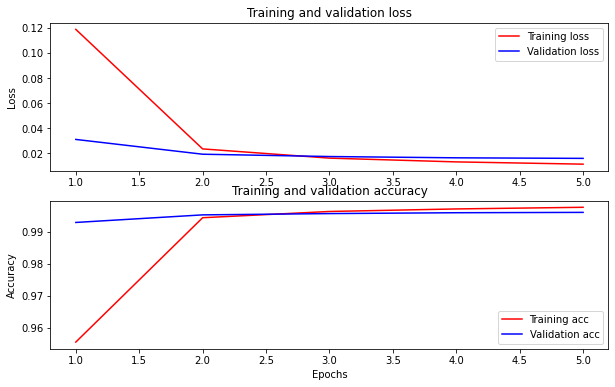

In [37]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
test_ds

<TensorSliceDataset shapes: ((1,), (1, 34)), types: (tf.string, tf.int64)>

In [26]:
##re-test on test_ds

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4871/4871 [==============================] - 123s 25ms/step - loss: 0.0154 - binary_accuracy: 0.9963
Loss: 0.015449981205165386
Accuracy: 0.9962809085845947


In [27]:
y_pred = classifier_model.predict(test_df['text'])

In [28]:
y_pred = np.round(y_pred)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [30]:
report = classification_report(test_df[labels], y_pred, output_dict=True)

C:\Users\Joe Z\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joe Z\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
labels.extend(('micro', 'macro', 'weighted', 'samples'))
labels

['feat_xr',
 'feat_ct',
 'feat_eeg',
 'feat_ecg',
 'feat_histo',
 'feat_mamm',
 'feat_endoscop',
 'feat_ehr',
 'spec_onc',
 'spec_psych',
 'spec_cvs',
 'spec_neuro',
 'spec_resp',
 'subspec_icu',
 'subspec_sepsis',
 'subspec_cov19',
 'subspec_dermca',
 'subspec_gynonc',
 'subspec_lungca',
 'subspec_brainca',
 'subspec_gica',
 'subspec_hepca',
 'subspec_prosca',
 'subspec_breast',
 'subspec_frac',
 'subspec_epilep',
 'subspec_cva',
 'subspec_alzh',
 'subspec_ihd',
 'subspec_dm',
 'spec_eye',
 'subspec_ackd',
 'spec_paeds',
 'subspec_arrhyt',
 'micro',
 'macro',
 'weighted',
 'samples']

In [32]:
report_df = pd.DataFrame(report).transpose()

In [33]:
report_df.index = labels
report_df

,precision,recall,f1-score,support
feat_xr,0.993939,0.993939,0.993939,165.0
feat_ct,0.958057,0.977477,0.967670,444.0
feat_eeg,0.981818,0.992647,0.987203,272.0
feat_ecg,0.956250,0.962264,0.959248,159.0
feat_histo,0.880503,0.939597,0.909091,298.0
feat_mamm,1.000000,1.000000,1.000000,74.0
feat_endoscop,0.987805,0.987805,0.987805,82.0
feat_ehr,0.944149,0.894207,0.918499,397.0
spec_onc,0.990028,0.980254,0.985117,1418.0
spec_psych,0.929348,0.900000,0.914439,380.0


In [38]:
report_df.to_csv('report.csv')

In [39]:
#print(classification_report(test_df[labels], y_pred, labels=labels))

In [40]:
#EXPORT MODEL

saved_model_path = 'models/multilabel_characteristics_bert'

classifier_model.save(saved_model_path, include_optimizer=False)